In [ ]:
#| default_exp core

The analysis of glycans is made difficult by their nonlinearity and their astounding diversity, given the large number of monosaccharides and types of linkages. Glycowork is a Python package designed to process and analyze glycan sequences, with a special emphasis on glycan-focused machine learning. Next to various functions to work with glycans, glycowork also contains some of the largest curated glycan datasets in the field, that can be used for model training, motif comparisons, composition matching, etc.

Where possible, glycowork uses the IUPAC-condensed nomenclature for glycans. However, since v1.0, glycowork broadly supports IUPAC-extended, LinearCode, Oxford, GlycoCT, and WURCS as input formats as well. No conversions or special settings are necessary.

If you do want to use IUPAC-condensed (still recommended), here are some best practices: An example for this would be `Man(a1-3)[Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc`, in which parentheses enclose the linkage description and brackets indicate branches. Ideally, the longest branch should constitute the main chain and side branches should be ordered ascendingly based on the last linkage of the branch (yet all functions in glycowork can deal with violations to these guidelines). Fragments with unclear attachment points are added within curly brackets. Where possible/known, monosaccharide modifications are indicated by the ring position to which they are attached (e.g., Glc6Me), while the type of connection is given if the exact position is unknown (e.g., GlcOMe). Linkage uncertainty is expressed with a '?' placeholder (e.g., a1-6, ?1-6, a1-?). As suggested in IUPAC-condensed, we omit the D-/L-prefix for the "usual" case and only add it for the rarer option (e.g., Glc vs. L-Glc).

However, it should be noted that nearly all functions in glycowork operate on pure graphs (facilitated by `glycowork.motif.graph.glycan_to_nxGraph`), avoiding all ambiguity of the IUPAC nomenclature. We use the IUPAC nomenclature here as a human-readable glycan nomenclature that can be readily used for motif interpretation and user-friendly usage. The conversion to graphs in all end user-functions and operations, such as motif annotation via highly optimized subgraph isomorphism tests, are handled behind the scenes, allowing you to work with glycans in a human-readable format.

In [ ]:
#| include: false
import warnings
warnings.filterwarnings("ignore")
from nbdev.showdoc import *
import copy
from IPython.display import HTML
import pandas as pd
from glycowork.glycan_data.loader import df_species
from glycowork.motif.analysis import plot_embeddings, get_heatmap, characterize_monosaccharide
from glycowork.motif.processing import presence_to_matrix
from glycowork.motif.query import get_insight
#%load_ext autoreload
#%autoreload 2

All modules in glycowork, **except** for `ml`, can be run on any machine. For most parts of `ml`, however, a GPU is needed to load and run torch_geometric.

If you want to run `glycowork.ml` in a Jupyter Notebook (in the cloud or wherever you have a GPU), just install glycowork with its optional dependencies for machine learning:
```
!pip install "glycowork[ml]"
```

Okay, how about an example! (For more example workflows, head over to the `examples` section) <br>
Let's say you're interested in glycans of the plant order Fabales that includes the legumes. Luckily, we've got you covered and `df_species` has >700 glycan sequences that stem from Fabales. So the first step is easy: import `df_species` from `glycowork.glycan_data.loader` and filter for Fabales glycans.

In [ ]:
df_fabales = df_species[df_species.Order == 'Fabales'].reset_index(drop = True)

In [ ]:
#| echo: false
df_fabales2 = copy.deepcopy(df_fabales)
df_fabales2.set_index("glycan", inplace = True)
df_fabales2 = df_fabales2.style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'})
style = df_fabales2.export()
df_fabales2.data.head().style.use(style)

,Species,Genus,Family,Order,Class,Phylum,Kingdom,Domain,ref
glycan,,,,,,,,,
Man(a1-2)Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-6)[Man(a1-3)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Abrus_precatorius,Abrus,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,gwb
Man(a1-2)Man(a1-3)[Man(a1-3)[Man(a1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Abrus_precatorius,Abrus,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,gwb
Man(a1-2)Man(a1-6)[Man(a1-3)]Man(a1-6)[Man(a1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Abrus_precatorius,Abrus,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,gwb
Man(a1-3)Man(a1-6)[Xyl(b1-2)][Man(a1-3)]Man(a1-6)Man(b1-4)GlcNAc(b1-4)GlcNAc,Abrus_precatorius,Abrus,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,nan
Man(a1-3)Man(a1-6)[Xyl(b1-2)][Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Abrus_precatorius,Abrus,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,nan


Now, if you're not a plant glycobiologist, that may seem a bit overwhelming to you. But fear not, we can just **plot** glycans. How? Easy: Glycan representations! <br>

Representations or embeddings are really just a bunch of numbers learned by a machine learning model that express similarity. Meaning that if two glycans are similar (in sequence/properties/etc.), the difference between their representations should be small. Or, in other words, they should cluster in a plot. <br>

Now, you might not be in possession of a GPU and/or the wherewithal to train a glycan-focused deep learning model. That's why `glycowork` has both trained models and **already calculated** glycan representations waiting for you! And the best thing: you don't even need to worry about them. You just pass glycan sequences to our functions and `glycowork` will handle glycan representations behind the scenes. <br>

So, for our Fabales example, we pass our glycan sequences to `glycowork.motif.analysis.plot_embeddings`, which will retrieve their learned representations, transform them into two dimensions via t-distributed stochastic neighbor embedding (t-SNE), and plot them! If you want, it can even color the resulting scatterplots by a label, for instance the taxonomic family within Fabales.

Download completed.


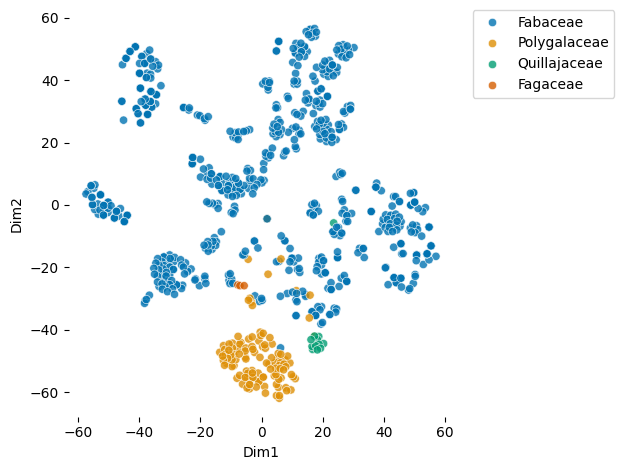

In [ ]:
plot_embeddings(df_fabales.glycan.values.tolist(), label_list = df_fabales.Family.values.tolist())

Hmm, interesting. We definitely see clear glycan clusters (remember, every point is one glycan sequence). What's even cooler is that the families Polygalaceae and Quillajaceae cluster in narrow regions of the whole plot. I wonder what differentiates their glycans from Fabaceae? <br>

If you're also curious, proceed to the next function. First, we need to convert our data into a count table, with counts of every glycan in every family of Fabales. For this, you can use `glycowork.motif.processing.presence_to_matrix`, which was designed to work with tables such as `df_species`. Changing `label_col_name` to 'Family' will for instance generate a count table for all families in Fabales.

In [ ]:
df_map = presence_to_matrix(df_fabales, label_col_name = 'Family').T

In [ ]:
#| echo: false
df_map2 = df_map.style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'})
style = df_map2.export()
df_map2.data.head().style.use(style)

Family,Fabaceae,Fagaceae,Polygalaceae,Quillajaceae
glycan,,,,
Apif(a1-2)Xyl(b1-2)[Glc6Ac(b1-4)]Glc,1,0,0,0
Ara(a1-2)Ara(a1-6)GlcNAc,4,0,0,0
Ara(a1-2)Glc(b1-2)Ara,1,0,0,0
Ara(a1-2)GlcA,3,0,0,0
Ara(a1-2)[Glc(b1-6)]Glc,1,0,0,0


Okay, we're ready for some heatmaps! In `glycowork.motif.analysis.get_heatmap`, we have a function which...makes heatmaps.<br>

Specifically, it will generate clustermaps, that are aiming to cluster samples based on their glycan profile. Calling `get_heatmap` with `df_map` without any other arguments will try to cluster the samples based on their full glycan sequences. But we also have the `motif` mode, which extracts motifs from these glycans and clusters samples based on those. For instance, you can use the `known` (curated glycan motifs) and the `exhaustive` (all observed monosaccharides and disaccharides) options. Check out the documentation for more options! <br>

We can immediately see that we have a lot more *N*-linked glycans in Fabaceae, for instance based on the prominence of Trimannosylcore and Fuc(a1-3)GlcNAc. Glycans from Polygalaceae and Quillajaceae in `df_species` seem to mainly contain small molecule- and lipid-linked glycans, which of course are quite different from *N*-linked glycans and are more similar to each other than to glycans from Fabaceae in `df_species`.

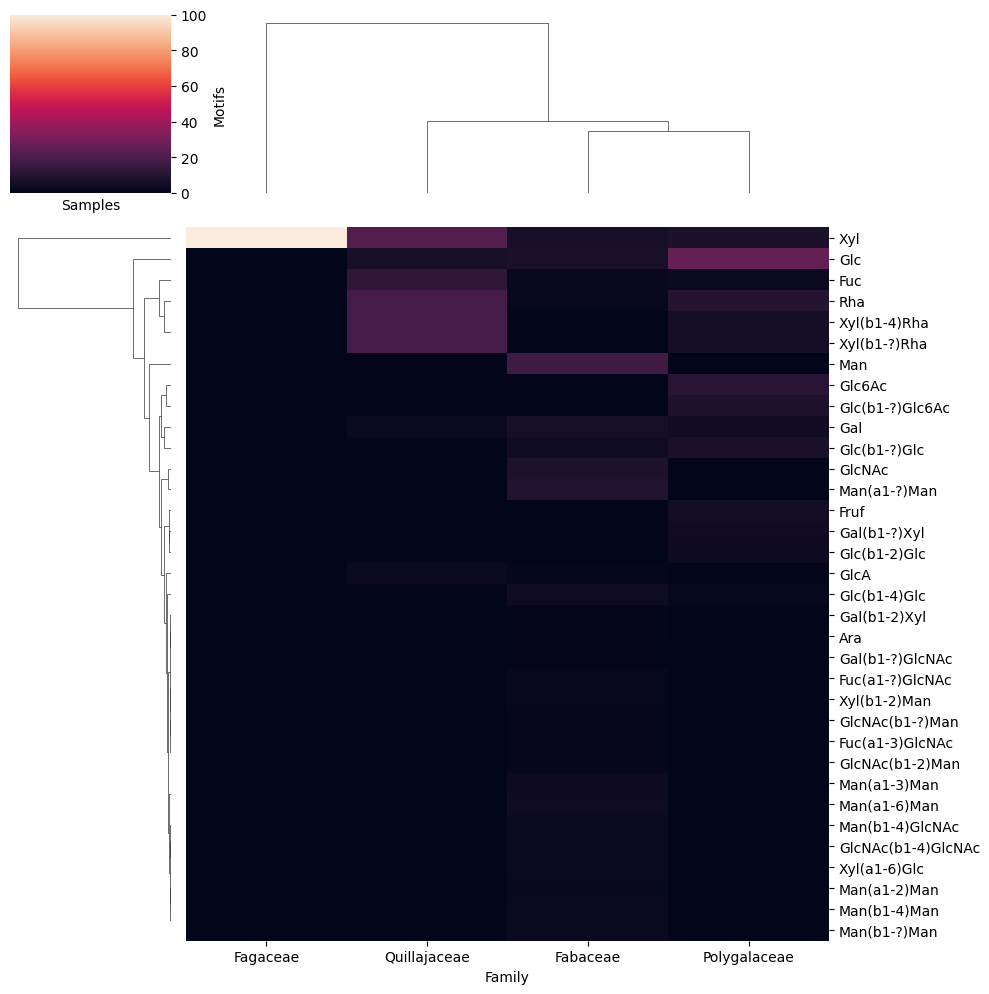

In [ ]:
get_heatmap(df_map, motifs = True, feature_set = ['exhaustive'], datatype = 'presence',
            show_all = True)

Let's say you're interested in a specific glycan from Fabales, `GlcNAc(b1-2)Man(a1-3)[GlcNAc(b1-2)Man(a1-6)][Xyl(b1-2)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-3)]GlcNAc`. Finding out more about it could be annoying (try to Google anything more complex than a short motif and you run into problems). That's why we have `glycowork.motif.query.get_insight`, a function that returns some metadata about that glycan. The nice thing is that you don't need to bother with database IDs or notational ambiguity, as `glycowork` will convert that glycan into a graph behind the scenes and search our databases.

Let's say you develop an acute interest in the distribution of xylose in plant glycans. In such a situation, one option for further inquiry would be `glycowork.motif.analysis.characterize_monosaccharide`. This neat little function allows you to get a sense of what a particular monosaccharide is typically directly connected to and which modifications it can acquire. Further, you can filter the results to any taxonomic level you're interested in! (as long as it's in `df_species` or your dataset of interest of course.) <br>
So, for xylose in plants, we immediately see Man (in M3X/M3FX structures) and Glc/Xyl (Xyloglucans) as prominent neighbors. Additionally, we note that xylose in plant glycans can be methylated, which is a rather typical modification in plant glycans in general. <br>
There is quite a bit more that you can do with `characterize_monosaccharide`, so have a look at its documentation for all the options!

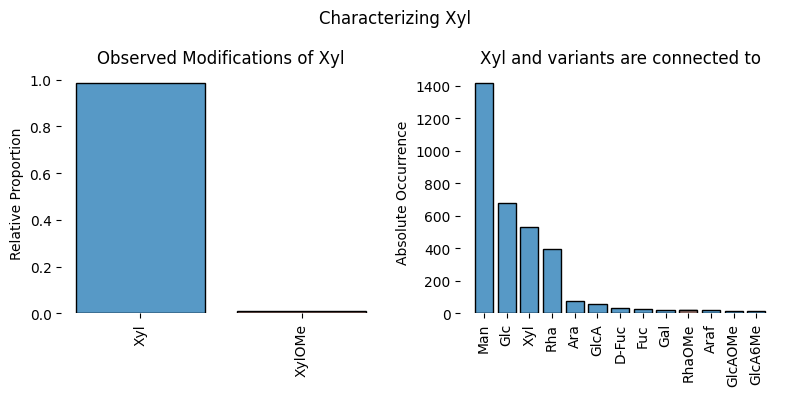

In [ ]:
characterize_monosaccharide('Xyl', rank = 'Kingdom', focus = 'Plantae', modifications = True)

To show you the true power of `characterize_monosaccharide` we'll switch gears to bacteria and have a look at how they handle their glucose connections. This is a lot more diverse than with xylose! Note how we put `thresh` to 50 (from its default value of 10), as otherwise the plot would become illegible with all the rare modifications and pairings.

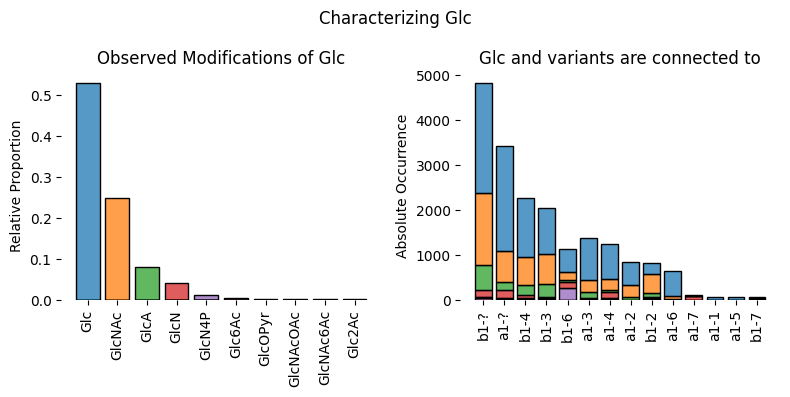

In [ ]:
characterize_monosaccharide('Glc', rank = 'Kingdom', mode = 'sugarbond',
                            focus = 'Bacteria', modifications = True, thresh = 50)

And that's just a super-brief glimpse at the really cool functions contained in `glycowork`! The rest of the documentation describes all functions and what they're good for. Be sure to check out more, suggest improvements/fixes, and maybe even contribute something yourself. We are looking forward to your discoveries!

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()